# 2024 年高教社杯全国大学生数学建模竞赛题目 E题  交通流量管控


## 问题一：
### 对经中路-纬中路交叉口，根据车流量的差异，可将一天分成若干个时段，估计不同时段各个相位（包括四个方向直行、转弯）车流量。



In [11]:
"""

数据预处理

"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置负号正常显示
plt.rcParams['axes.unicode_minus'] = False

# 清空问题1支撑材料文件夹里的文件
import os
files = os.listdir('./问题1支撑材料')
for file in files:
    file_path = os.path.join('./问题1支撑材料', file)
    if os.path.isfile(file_path):
        os.remove(file_path)
# 读取数据
df1 = pd.read_csv('./题目及附件/附件2.csv', encoding='gbk')

# 查看交叉口为经中路-纬中路的数据
df1_zz = df1[df1['交叉口'] == '经中路-纬中路']



In [12]:
# 检查缺失值
missing_values = df1_zz.isnull().sum()
print("缺失值统计：")
print(missing_values[missing_values > 0])

# 检查重复值
duplicate_rows = df1_zz.duplicated().sum()
print(f"重复行数：{duplicate_rows}")

# 检查数据格式
print("数据类型统计：")
print(df1_zz.dtypes)

# 统一所有时间格式
df1_zz['时间'] = pd.to_datetime(df1_zz['时间'], errors='coerce')
# 检查转换后的时间格式
print("时间列数据类型：", df1_zz['时间'].dtype)

# 检查车牌号为“无车牌” 的数据作为异常值
df1_zz_invalid = df1_zz[df1_zz['车牌号'] == '无车牌']

# 剔除异常值
df1_zz = df1_zz[df1_zz['车牌号'] != '无车牌']

# 检查清洗后的数据
print("清洗后的数据统计：")
print(df1_zz.head())

缺失值统计：
Series([], dtype: int64)
重复行数：0
数据类型统计：
方向      int64
时间     object
车牌号    object
交叉口    object
dtype: object
时间列数据类型： datetime64[ns]
清洗后的数据统计：
       方向                  时间       车牌号      交叉口
7881    4 2024-04-03 13:47:18   AF45D87  经中路-纬中路
7882    4 2024-04-01 21:16:31   AFXBA37  经中路-纬中路
7883    4 2024-04-01 21:14:07   EF8U5E0  经中路-纬中路
7884    4 2024-04-01 10:12:40  AB3F68FK  经中路-纬中路
37220   4 2024-04-01 09:17:32   AF2U9DD  经中路-纬中路


C:\Users\hhui8\AppData\Local\Temp\ipykernel_25696\2357691290.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_zz['时间'] = pd.to_datetime(df1_zz['时间'], errors='coerce')


In [13]:
# 检查数据包含的日期从哪天到哪天
start_date = df1_zz['时间'].min()
end_date = df1_zz['时间'].max()
print(f"数据包含的日期从 {start_date} 到 {end_date}")

数据包含的日期从 2024-04-01 00:00:59 到 2024-05-06 23:59:59


工作日和节假日统计：
工作日
True     648934
False    452353
Name: count, dtype: int64


C:\Users\hhui8\AppData\Local\Temp\ipykernel_25696\3145986967.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='工作日', data=df1_zz, palette='Set2')


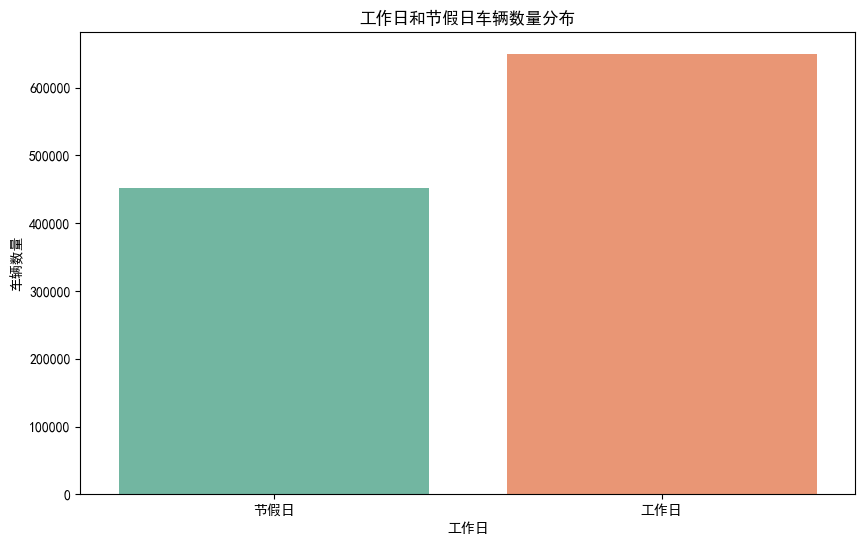

In [14]:
# 将时间按日期划分成工作日和节假日
# 将周一至周五划分工作日，周六周日划分为节假日
df1_zz['日期'] = df1_zz['时间'].dt.date
df1_zz['工作日'] = df1_zz['时间'].dt.dayofweek < 5
# 将4月4号划分为节假日
df1_zz.loc[df1_zz['日期'] == pd.to_datetime('2024-04-04').date(), '工作日'] = False
df1_zz.loc[df1_zz['日期'] == pd.to_datetime('2024-04-05').date(), '工作日'] = False
# 将4月7号和4月28号划分为工作日
df1_zz.loc[df1_zz['日期'] == pd.to_datetime('2024-04-07').date(), '工作日'] = True
df1_zz.loc[df1_zz['日期'] == pd.to_datetime('2024-04-28').date(), '工作日'] = True
# 将5月1号至5月5号划分为节假日
for date in pd.date_range(start='2024-05-01', end='2024-05-05'):
    df1_zz.loc[df1_zz['日期'] == date.date(), '工作日'] = False

# 检查工作日和节假日的划分
print("工作日和节假日统计：")
print(df1_zz['工作日'].value_counts())
# 保存清洗后的数据
df1_zz.to_csv('./问题1支撑材料/节假日划分.csv', index=False, encoding='gbk')
# 可视化工作日和节假日的车辆数量分布
plt.figure(figsize=(10, 6))
sns.countplot(x='工作日', data=df1_zz, palette='Set2')
plt.title('工作日和节假日车辆数量分布')
plt.xlabel('工作日')
plt.ylabel('车辆数量')
plt.xticks(ticks=[0, 1], labels=['节假日', '工作日'])
plt.show()

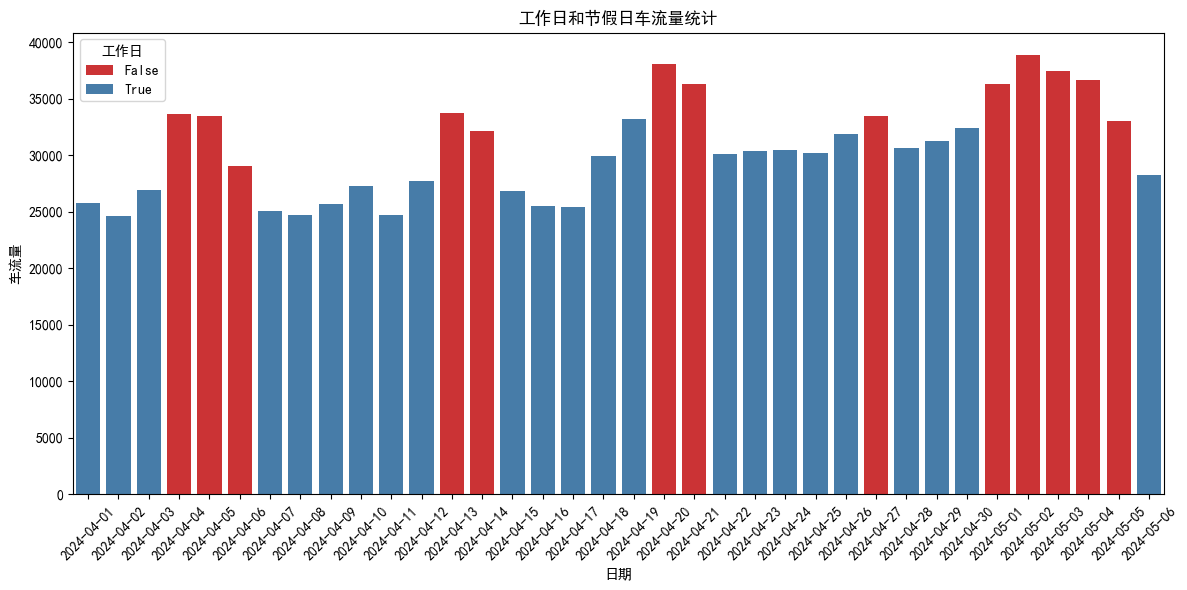

In [15]:
# 统计车流量，将工作日和节假日的车流量进行统计
traffic_count = df1_zz.groupby(['日期', '工作日']).size().reset_index(name='车流量')
# 可视化工作日和节假日的车流量
plt.figure(figsize=(12, 6))
sns.barplot(x='日期', y='车流量', hue='工作日', data=traffic_count, palette='Set1')
plt.title('工作日和节假日车流量统计')
plt.xlabel('日期')
plt.ylabel('车流量')
plt.xticks(rotation=45)
plt.legend(title='工作日')
plt.tight_layout()
# 保存图片
plt.savefig('./问题1支撑材料/工作日和节假日车流量统计.png')
plt.show()


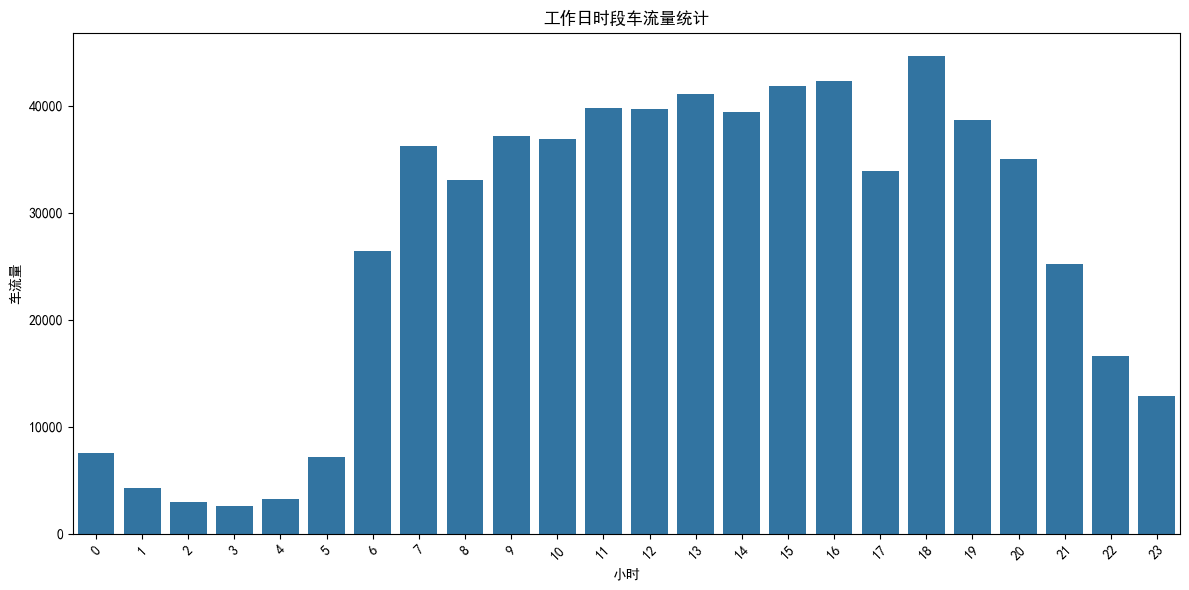

In [16]:
# 统计工作日的时段车流量
traffic_by_time = df1_zz[df1_zz['工作日']].groupby(df1_zz['时间'].dt.hour).size().reset_index(name='车流量')
# 可视化工作日时段车流量，颜色单调一点
plt.figure(figsize=(12, 6))
sns.barplot(x='时间', y='车流量', data=traffic_by_time)
plt.xticks(ticks=range(0, 24), labels=range(0, 24), rotation=45)
plt.title('工作日时段车流量统计')
plt.xlabel('小时')
plt.ylabel('车流量')
plt.tight_layout()
# 保存工作日时段车流量统计图
plt.savefig('./问题1支撑材料/工作日时段车流量统计.png')
plt.show()

# 将工作日时段车流量数据保存为csv文件
traffic_by_time.to_csv('./问题1支撑材料/工作日时段车流量.csv', index=False, encoding='gbk')

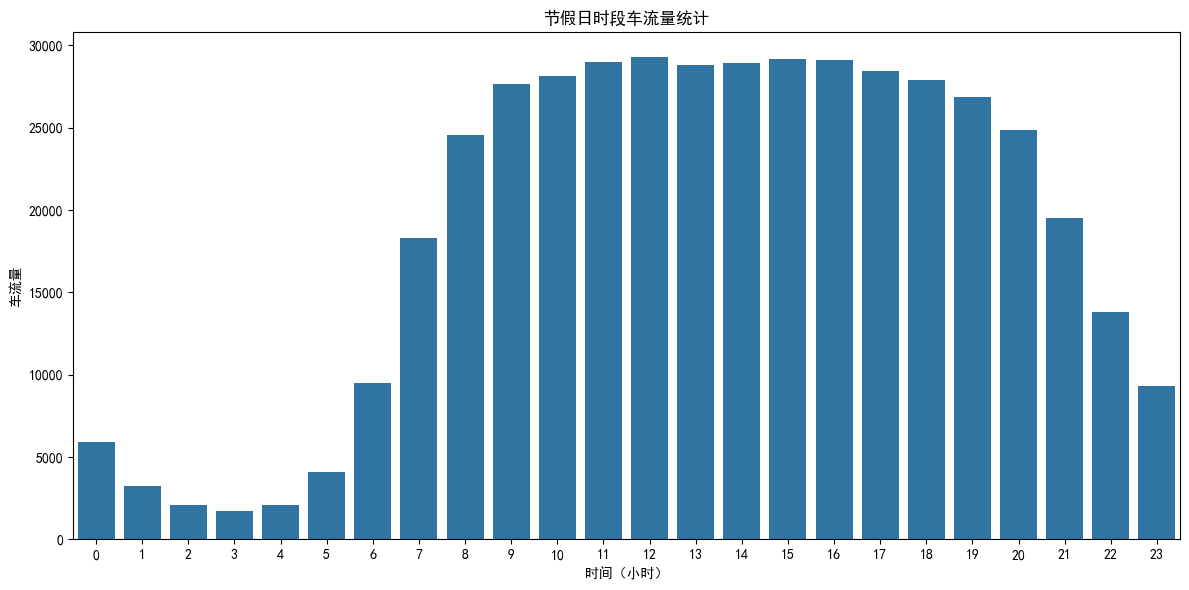

In [17]:
# 统计节假日的时段车流量
traffic_by_time_holiday = df1_zz[~df1_zz['工作日']].groupby(df1_zz['时间'].dt.hour).size().reset_index(name='车流量')
plt.figure(figsize=(12, 6))
sns.barplot(x='时间', y='车流量', data=traffic_by_time_holiday)
plt.title('节假日时段车流量统计')
plt.xlabel('时间（小时）')
plt.ylabel('车流量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('./问题1支撑材料/节假日时段车流量统计.png')
plt.show()
# 将节假日时段车流量数据保存为csv文件
traffic_by_time_holiday.to_csv('./问题1支撑材料/节假日时段车流量.csv', index=False, encoding='gbk')

In [18]:
# 先确保“时间”列为小时整数
df1_zz['小时'] = df1_zz['时间'].dt.hour

# 只取工作日数据
df_workday = df1_zz[df1_zz['工作日']]

# 生成透视表：行是小时，列是方向，值是车流量
pivot_table = df_workday.pivot_table(index='小时', columns='方向', values='车牌号', aggfunc='count', fill_value=0)

# 重置索引，方便保存和查看
pivot_table = pivot_table.reset_index()

# 保存为csv
pivot_table.to_csv('./问题1支撑材料/工作日各方向分时段车流量.csv', index=False, encoding='gbk')

# 显示前几行
print(pivot_table.head())

# 只取节假日数据
df_holiday = df1_zz[~df1_zz['工作日']]
# 生成透视表：行是小时，列是方向，值是车流量
pivot_table_holiday = df_holiday.pivot_table(index='小时', columns='方向', values='车牌号', aggfunc='count', fill_value=0)
# 重置索引，方便保存和查看
pivot_table_holiday = pivot_table_holiday.reset_index()
# 保存为csv
pivot_table_holiday.to_csv('./问题1支撑材料/节假日各方向分时段车流量.csv', index=False, encoding='gbk')
# 显示前几行
print(pivot_table_holiday.head())

方向  小时     1    2     3     4
0    0  2456  888  1426  2753
1    1  1394  455   910  1563
2    2   991  276   715   976
3    3   568  261   643  1145
4    4   604  341   591  1717
方向  小时     1    2     3     4
0    0  1964  871  1038  2012
1    1  1055  473   581  1096
2    2   664  262   474   649
3    3   408  202   355   724
4    4   408  291   342  1050


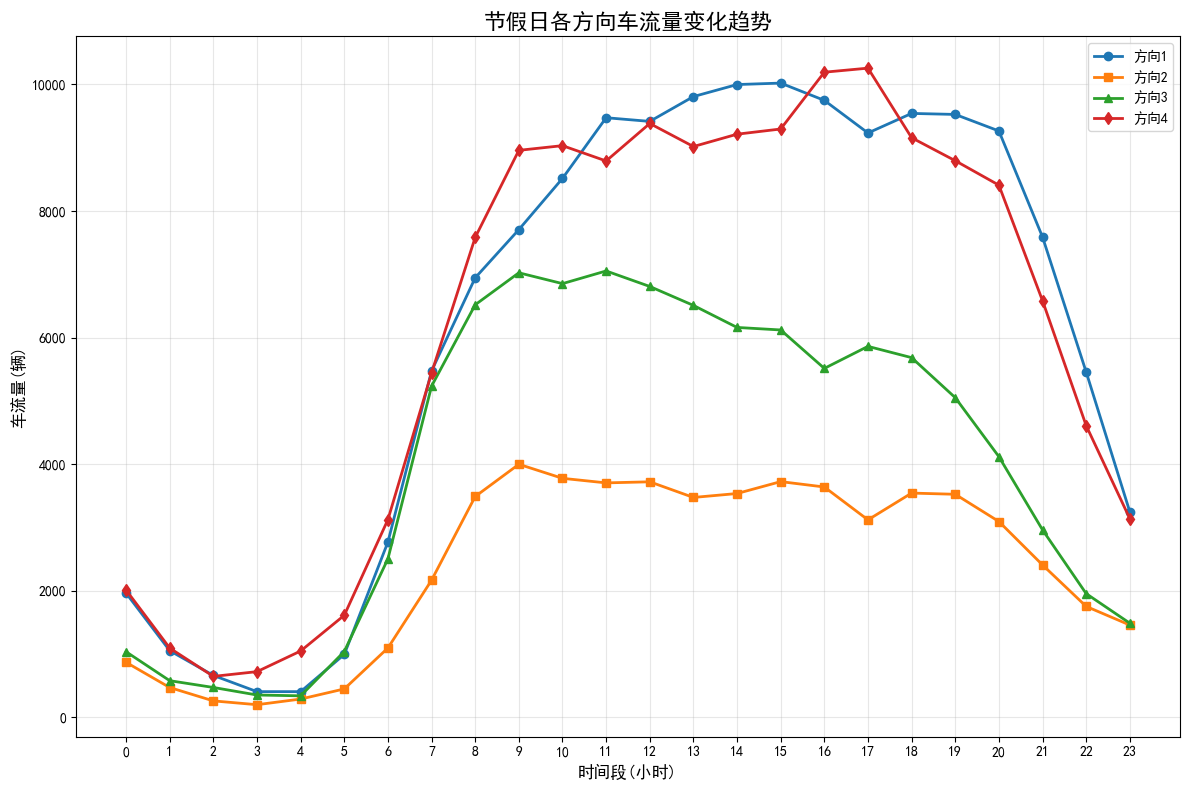

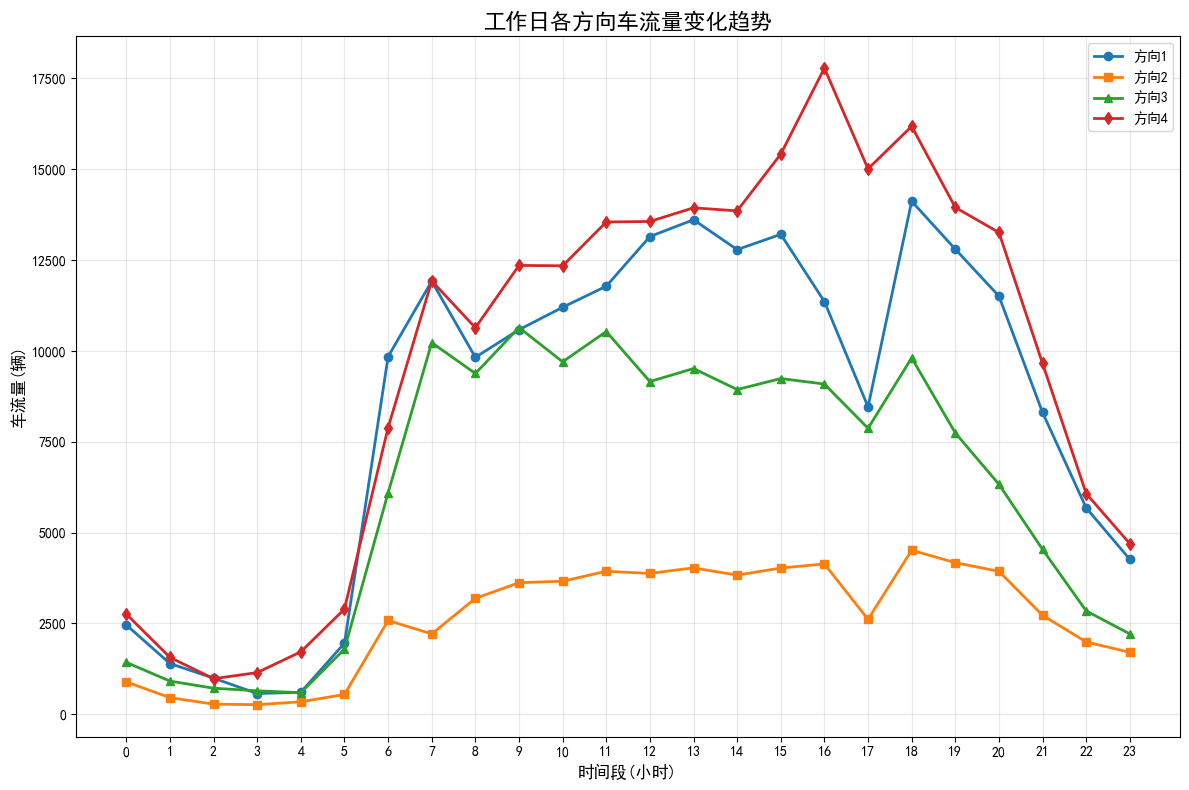

工作日各方向总车流量:
方向1: 202378辆
方向2: 63484辆
方向3: 149928辆
方向4: 233144辆

节假日各方向总车流量:
方向1: 149205辆
方向2: 57794辆
方向3: 97246辆
方向4: 148108辆

工作日各方向车流量占比:
方向1: 31.19%
方向2: 9.78%
方向3: 23.10%
方向4: 35.93%

节假日各方向车流量占比:
方向1: 32.98%
方向2: 12.78%
方向3: 21.50%
方向4: 32.74%


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
weekday_data = pd.read_csv('./问题1支撑材料/工作日各方向分时段车流量.csv')
holiday_data = pd.read_csv('./问题1支撑材料/节假日各方向分时段车流量.csv')

# 创建节假日四个方向车流量折线图
plt.figure(figsize=(12, 8))

plt.plot(holiday_data['Сʱ'], holiday_data['1'], marker='o', linewidth=2, label='方向1')
plt.plot(holiday_data['Сʱ'], holiday_data['2'], marker='s', linewidth=2, label='方向2')
plt.plot(holiday_data['Сʱ'], holiday_data['3'], marker='^', linewidth=2, label='方向3')
plt.plot(holiday_data['Сʱ'], holiday_data['4'], marker='d', linewidth=2, label='方向4')

plt.title('节假日各方向车流量变化趋势', fontsize=16, fontweight='bold')
plt.xlabel('时间段(小时)', fontsize=12)
plt.ylabel('车流量(辆)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 设置x轴刻度
plt.xticks(range(0, 24, 1))

# 保存节假日图表
plt.tight_layout()
plt.savefig('./问题1支撑材料/节假日各方向车流量.png', dpi=300, bbox_inches='tight')
plt.show()

# 创建工作日四个方向车流量折线图
plt.figure(figsize=(12, 8))

plt.plot(weekday_data['Сʱ'], weekday_data['1'], marker='o', linewidth=2, label='方向1')
plt.plot(weekday_data['Сʱ'], weekday_data['2'], marker='s', linewidth=2, label='方向2')
plt.plot(weekday_data['Сʱ'], weekday_data['3'], marker='^', linewidth=2, label='方向3')
plt.plot(weekday_data['Сʱ'], weekday_data['4'], marker='d', linewidth=2, label='方向4')

plt.title('工作日各方向车流量变化趋势', fontsize=16, fontweight='bold')
plt.xlabel('时间段(小时)', fontsize=12)
plt.ylabel('车流量(辆)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 设置x轴刻度
plt.xticks(range(0, 24, 1))

# 保存工作日图表
plt.tight_layout()
plt.savefig('./问题1支撑材料/工作日各方向车流量.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出各方向总车流量统计
print('工作日各方向总车流量:')
for col in ['1', '2', '3', '4']:
    total = weekday_data[col].sum()
    print(f'方向{col}: {total}辆')
    
print('\n节假日各方向总车流量:')
for col in ['1', '2', '3', '4']:
    total = holiday_data[col].sum()
    print(f'方向{col}: {total}辆')
    
# 计算并输出各方向车流量占比
print('\n工作日各方向车流量占比:')
weekday_totals = [weekday_data[str(i)].sum() for i in range(1, 5)]
weekday_sum = sum(weekday_totals)
for i, total in enumerate(weekday_totals, 1):
    percentage = total / weekday_sum * 100
    print(f'方向{i}: {percentage:.2f}%')
    
print('\n节假日各方向车流量占比:')
holiday_totals = [holiday_data[str(i)].sum() for i in range(1, 5)]
holiday_sum = sum(holiday_totals)
for i, total in enumerate(holiday_totals, 1):
    percentage = total / holiday_sum * 100
    print(f'方向{i}: {percentage:.2f}%')

In [20]:

from sklearn.preprocessing import StandardScaler

data_workday = pd.read_csv('./问题1支撑材料/工作日时段车流量.csv', encoding='gbk')
data_holiday = pd.read_csv('./问题1支撑材料/节假日时段车流量.csv', encoding='gbk')

# 通过z-score方法检验异常值并剔除异常值
from scipy import stats
data_workday['z_score'] = np.abs(stats.zscore(data_workday['车流量']))
data_holiday['z_score'] = np.abs(stats.zscore(data_holiday['车流量']))
data_workday = data_workday[data_workday['z_score'] < 3]
data_holiday = data_holiday[data_holiday['z_score'] < 3]

# 对数据进行标准化处理
scaler = StandardScaler()
data_workday_scaled = scaler.fit_transform(data_workday[['车流量']])
data_holiday_scaled = scaler.fit_transform(data_holiday[['车流量']])




# 检查数据
print("工作日数据统计：")
print(data_workday.head())
print("节假日数据统计：")
print(data_holiday.head())




工作日数据统计：
   时间   车流量   z_score
0   0  7523  1.306420
1   1  4322  1.520699
2   2  2958  1.612007
3   3  2617  1.634834
4   4  3253  1.592260
节假日数据统计：
   时间   车流量   z_score
0   0  5885  1.202285
1   1  3205  1.450847
2   2  2049  1.558063
3   3  1689  1.591452
4   4  2091  1.554168


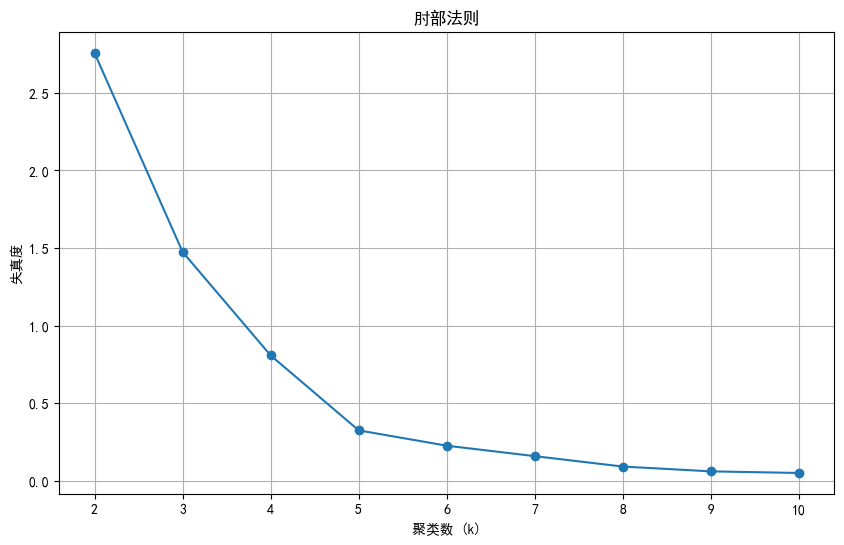

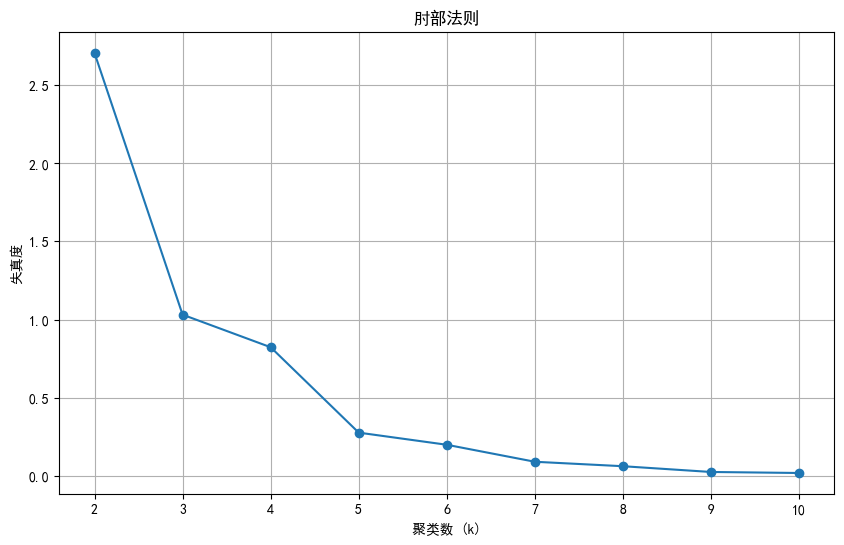

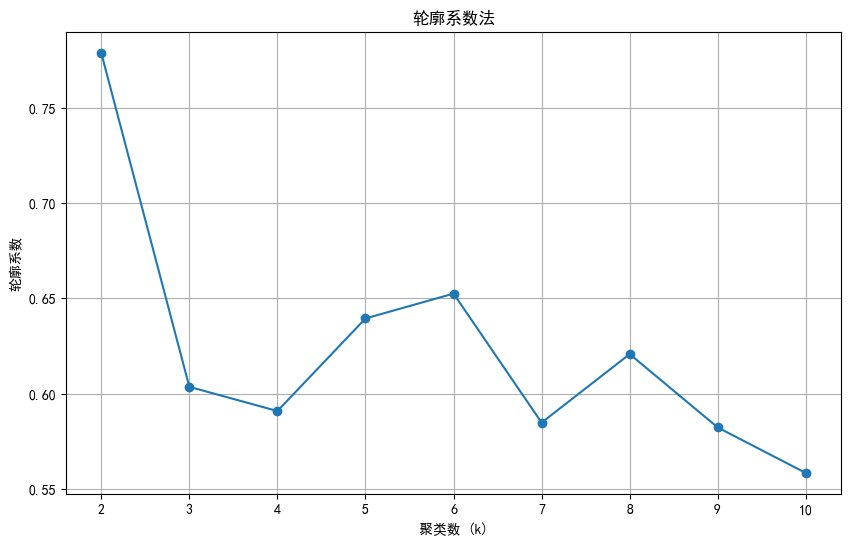

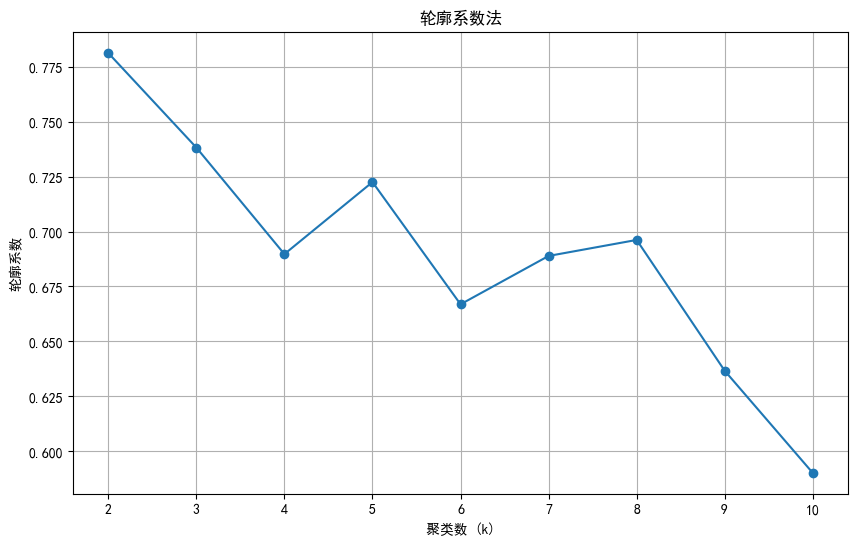

In [21]:
"""

问题一解决，使用k-means算法对工作日和节假日的车流量进行聚类分析,进行划分时段

"""


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 通过肘部法则和轮廓系数法这两种方法来确定最佳的聚类数
def find_optimal_clusters(data, max_k=10):
    """
    使用肘部法则和轮廓系数法来确定最佳的聚类数
    """
    distortions = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        
        # 计算肘部法则的失真度
        distortions.append(kmeans.inertia_)
        
        # 计算轮廓系数
        if k > 1:
            score = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(score)
    
    return distortions, silhouette_scores

# 使用肘部法则和轮廓系数法来确定最佳的聚类数
distortions_workday, silhouette_scores_workday = find_optimal_clusters(data_workday_scaled)
distortions_holiday, silhouette_scores_holiday = find_optimal_clusters(data_holiday_scaled)

def plot_elbow_method(distortions, filename=None):
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, len(distortions) + 2), distortions, marker='o')
    plt.title('肘部法则')
    plt.xlabel('聚类数 (k)')
    plt.ylabel('失真度')
    plt.xticks(range(2, len(distortions) + 2))
    plt.grid()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_silhouette_scores(silhouette_scores, filename=None):
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
    plt.title('轮廓系数法')
    plt.xlabel('聚类数 (k)')
    plt.ylabel('轮廓系数')
    plt.xticks(range(2, len(silhouette_scores) + 2))
    plt.grid()
    if filename:
        plt.savefig(filename)
    plt.show()

# 绘图并保存
plot_elbow_method(distortions_workday, './问题1支撑材料/肘部法则_workday.png')
plot_elbow_method(distortions_holiday, './问题1支撑材料/肘部法则_holiday.png')
plot_silhouette_scores(silhouette_scores_workday, './问题1支撑材料/轮廓系数_workday.png')
plot_silhouette_scores(silhouette_scores_holiday, './问题1支撑材料/轮廓系数_holiday.png')



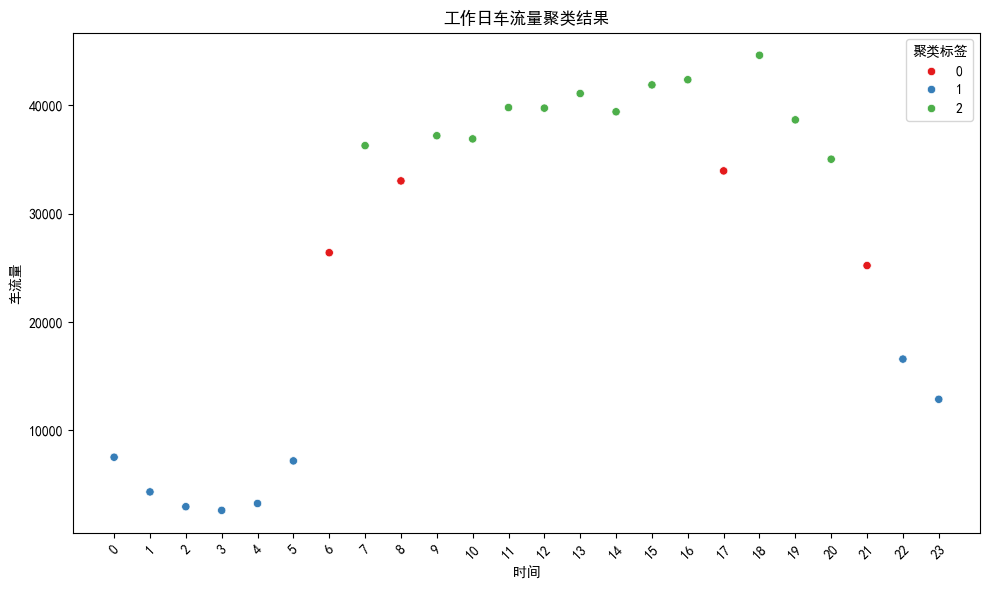

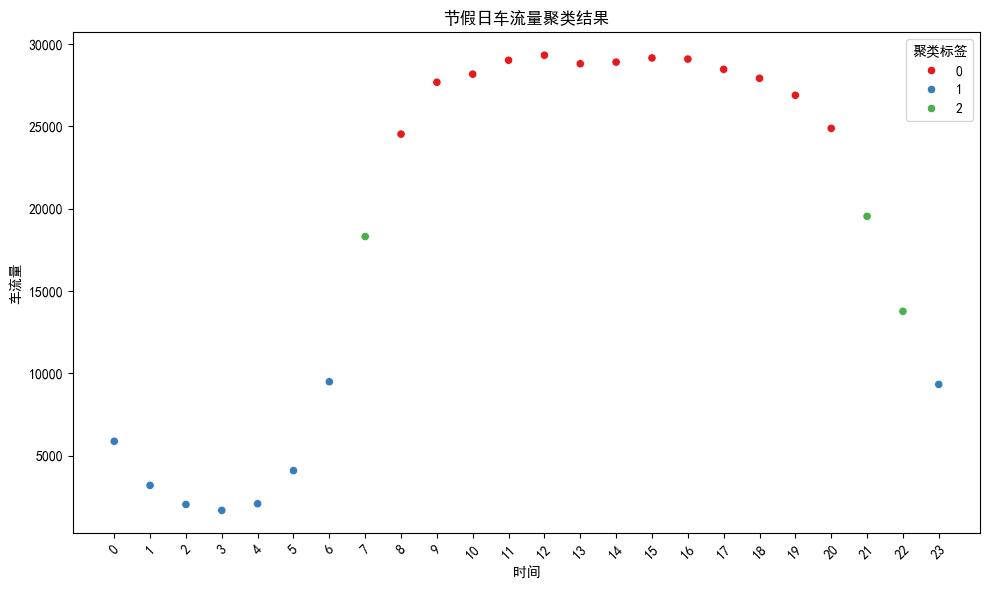

In [22]:
# 对工作日数据进行聚类分析，确保当时间相同的时候，该时间段的车流量被聚类到同一类
# 让聚类分析结果更好，确保每个时间段的车流量被聚类到同一类
# 聚类分析是需要划分3个簇，基于当前簇中心计算新的质心，再基于新的质心重新划分3个簇，再次更新，一直循环往复，直到再次更新，簇不发生任何变化为止
kmeans_workday = KMeans(n_clusters=3, random_state=42)
kmeans_workday.fit(data_workday_scaled)
# 对节假日数据进行聚类分析
kmeans_holiday = KMeans(n_clusters=3, random_state=42)
kmeans_holiday.fit(data_holiday_scaled)

# 将聚类结果添加到数据中
data_workday['聚类标签'] = kmeans_workday.labels_
# 可视化工作日聚类结果
plt.figure(figsize=(10, 6)) # 设置图形大小
sns.scatterplot(x='时间', y='车流量', hue='聚类标签', data=data_workday, palette='Set1') # 将每个小时都显示出来
plt.title('工作日车流量聚类结果')
plt.xlabel('时间')
plt.ylabel('车流量')
plt.xticks(rotation=45, ticks=data_workday["时间"]) # 将x轴标签旋转45度
plt.legend(title='聚类标签')
plt.tight_layout()
plt.savefig('./问题1支撑材料/工作日车流量聚类结果.png')
plt.show()


# 将聚类结果添加到数据中
data_holiday['聚类标签'] = kmeans_holiday.labels_
# 可视化节假日聚类结果,将每个小时都显示出来
# 可视化节假日聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='时间', y='车流量', hue='聚类标签',
                data=data_holiday, palette='Set1')
plt.title('节假日车流量聚类结果')
plt.xlabel('时间')
plt.ylabel('车流量')
plt.xticks(rotation=45,ticks=data_holiday["时间"])
plt.legend(title='聚类标签')
plt.tight_layout() # 自动调整子图参数，使之填充整个图像区域
plt.savefig('./问题1支撑材料/节假日车流量聚类结果.png')
plt.show()

In [23]:
# 划分时段
def assign_time_period_work(row):
    if row['聚类标签'] == 0:
        return '平峰'
    elif row['聚类标签'] == 1:
        return '低峰'
    elif row['聚类标签'] == 2:
        return '高峰'
def assign_time_period_holiday(row):
    if row['聚类标签'] == 0:
        return '高峰'
    elif row['聚类标签'] == 1:
        return '低峰'
    elif row['聚类标签'] == 2:
        return '平峰'
    
data_workday['时段'] = data_workday.apply(assign_time_period_work, axis=1)
data_holiday['时段'] = data_holiday.apply(assign_time_period_holiday, axis=1)



# 将工作日和节假日的时段数据保存为csv文件
data_workday.to_csv('./问题1支撑材料/工作日时段车流量.csv', index=False, encoding='gbk')
data_holiday.to_csv('./问题1支撑材料/节假日时段车流量.csv', index=False, encoding='gbk')


In [24]:
# 1. 读取节假日时段聚类标签和时段划分
data_holiday = pd.read_csv('./问题1支撑材料/节假日时段车流量.csv', encoding='gbk')
# 确保有“时间”列（小时），如果没有请用 data_holiday['时间'] = data_holiday['小时']

# 2. 读取节假日各方向分时段车流量的透视表
pivot_table_holiday = pd.read_csv('./问题1支撑材料/节假日各方向分时段车流量.csv', encoding='gbk')

# 3. 合并聚类标签和时段到透视表
# 先把聚类标签和时段信息合并到pivot_table_holiday
pivot_table_holiday = pd.merge(
    pivot_table_holiday,
    data_holiday[['时间', '聚类标签', '时段']],
    left_on='小时', right_on='时间', how='left'
)

# 4. 删除多余的“时间”列
pivot_table_holiday = pivot_table_holiday.drop(columns=['时间'])

# 5. 调整列顺序：小时、1、2、3、4、聚类标签、时段
cols = ['小时', '1', '2', '3', '4', '聚类标签', '时段']
pivot_table_holiday = pivot_table_holiday[cols]

# 6. 保存结果
pivot_table_holiday.to_csv('./问题1支撑材料/节假日分方向分时段车流量_带聚类标签.csv', index=False, encoding='gbk')

# 7. 显示前几行
print(pivot_table_holiday.head())



   小时     1    2     3     4  聚类标签  时段
0   0  1964  871  1038  2012     1  低峰
1   1  1055  473   581  1096     1  低峰
2   2   664  262   474   649     1  低峰
3   3   408  202   355   724     1  低峰
4   4   408  291   342  1050     1  低峰


In [25]:
# 读取工作日时段聚类标签和时段划分
data_workday = pd.read_csv('./问题1支撑材料/工作日时段车流量.csv', encoding='gbk')  
# 读取工作日各方向分时段车流量的透视表
pivot_table_workday = pd.read_csv('./问题1支撑材料/工作日各方向分时段车流量.csv', encoding='gbk')
# 合并聚类标签和时段到透视表
pivot_table_workday = pd.merge(
    pivot_table_workday,
    data_workday[['时间', '聚类标签', '时段']],
    left_on='小时', right_on='时间', how='left'
)
# 删除多余的“时间”列
pivot_table_workday = pivot_table_workday.drop(columns=['时间'])
# 调整列顺序：小时、1、2、3、4、聚类标签、时段
cols = ['小时', '1', '2', '3', '4', '聚类标签', '时段']
pivot_table_workday = pivot_table_workday[cols]
# 保存结果
pivot_table_workday.to_csv('./问题1支撑材料/工作日分方向分时段车流量_带聚类标签.csv', index=False, encoding='gbk')
# 显示前几行
print(pivot_table_workday.head())


   小时     1    2     3     4  聚类标签  时段
0   0  2456  888  1426  2753     1  低峰
1   1  1394  455   910  1563     1  低峰
2   2   991  276   715   976     1  低峰
3   3   568  261   643  1145     1  低峰
4   4   604  341   591  1717     1  低峰


In [26]:
"""

通过粒子群算法，确定车辆转向和直行的比例

"""
import numpy as np
from pyswarm import pso

# 初始化粒子群
def objective_function(x, total_flow):
    """
    目标函数：min(abs(估计左转的车流量+估计右转的车流量+估计直行的车流量-实际车流量))
    """
    # 定义决策变量
    left_turn_ratio = x[0]  # 左转概率
    right_turn_ratio = x[1]  # 右转概率
    straight_ratio = 1 - left_turn_ratio - right_turn_ratio  # 直行概率
    if straight_ratio < 0:
        return float('inf')  # 如果直行概率小于0，返回无穷大
    # 计算估计的车流量
    estimated_left_turn = left_turn_ratio * total_flow
    estimated_right_turn = right_turn_ratio * total_flow
    estimated_straight = straight_ratio * total_flow
    # 计算目标函数值
    return abs(estimated_left_turn + estimated_right_turn + estimated_straight - total_flow)
def optimize_turn_ratios(total_flow):
    """
    使用粒子群算法优化左转、右转和直行的比例
    """
    # 粒子群算法的边界
    lb = [0, 0]  # 左转和右转的最小比例
    ub = [0.5, 0.5]  # 左转和右转的最大比例
    # 使用粒子群算法进行优化
    xopt, fopt = pso(objective_function, lb, ub, args=(total_flow,))
    return xopt, fopt

# 导入数据
traffic_data_workday = pd.read_csv('./问题1支撑材料/工作日分方向分时段车流量_带聚类标签.csv', encoding='gbk')
traffic_data_holiday = pd.read_csv('./问题1支撑材料/节假日分方向分时段车流量_带聚类标签.csv', encoding='gbk')

# 计算每个时段（低峰、高峰、平峰）的每个方向上的总流量

# 计算工作日的低峰期的4个方向上的总流量
total_flow_workday_low_1 = traffic_data_workday[traffic_data_workday['时段'] == '低峰']['1'].sum() 
total_flow_workday_low_2 = traffic_data_workday[traffic_data_workday['时段'] == '低峰']['2'].sum()
total_flow_workday_low_3 = traffic_data_workday[traffic_data_workday['时段'] == '低峰']['3'].sum()
total_flow_workday_low_4 = traffic_data_workday[traffic_data_workday['时段'] == '低峰']['4'].sum()
# 查看结果
print(f"工作日低峰期各个方向的总车流量: 1: {total_flow_workday_low_1}, 2: {total_flow_workday_low_2}, 3: {total_flow_workday_low_3}, 4: {total_flow_workday_low_4}")

# 计算工作日中峰期的4个方向上的总流量
total_flow_workday_mid_1 = traffic_data_workday[traffic_data_workday['时段'] == '平峰']['1'].sum()
total_flow_workday_mid_2 = traffic_data_workday[traffic_data_workday['时段'] == '平峰']['2'].sum()
total_flow_workday_mid_3 = traffic_data_workday[traffic_data_workday['时段'] == '平峰']['3'].sum()
total_flow_workday_mid_4 = traffic_data_workday[traffic_data_workday['时段'] == '平峰']['4'].sum()
# 查看结果
print(f"工作日平峰期各个方向的总车流量: 1: {total_flow_workday_mid_1}, 2: {total_flow_workday_mid_2}, 3: {total_flow_workday_mid_3}, 4: {total_flow_workday_mid_4}")
# 计算工作日高峰期的4个方向上的总流量
total_flow_workday_high_1 = traffic_data_workday[traffic_data_workday['时段'] == '高峰']['1'].sum()
total_flow_workday_high_2 = traffic_data_workday[traffic_data_workday['时段'] == '高峰']['2'].sum()
total_flow_workday_high_3 = traffic_data_workday[traffic_data_workday['时段'] == '高峰']['3'].sum()
total_flow_workday_high_4 = traffic_data_workday[traffic_data_workday['时段'] == '高峰']['4'].sum()
# 查看结果
print(f"工作日高峰期各个方向的总车流量: 1: {total_flow_workday_high_1}, 2: {total_flow_workday_high_2}, 3: {total_flow_workday_high_3}, 4: {total_flow_workday_high_4}")
# 计算节假日低峰期的4个方向上的总流量
total_flow_holiday_low_1 = traffic_data_holiday[traffic_data_holiday['时段'] == '低峰']['1'].sum()
total_flow_holiday_low_2 = traffic_data_holiday[traffic_data_holiday['时段'] == '低峰']['2'].sum()
total_flow_holiday_low_3 = traffic_data_holiday[traffic_data_holiday['时段'] == '低峰']['3'].sum()
total_flow_holiday_low_4 = traffic_data_holiday[traffic_data_holiday['时段'] == '低峰']['4'].sum()
# 查看结果
print(f"节假日低峰期各个方向的总车流量: 1: {total_flow_holiday_low_1}, 2: {total_flow_holiday_low_2}, 3: {total_flow_holiday_low_3}, 4: {total_flow_holiday_low_4}")
# 计算节假日中峰期的4个方向上的总流量
total_flow_holiday_mid_1 = traffic_data_holiday[traffic_data_holiday['时段'] == '平峰']['1'].sum()
total_flow_holiday_mid_2 = traffic_data_holiday[traffic_data_holiday['时段'] == '平峰']['2'].sum()
total_flow_holiday_mid_3 = traffic_data_holiday[traffic_data_holiday['时段'] == '平峰']['3'].sum()
total_flow_holiday_mid_4 = traffic_data_holiday[traffic_data_holiday['时段'] == '平峰']['4'].sum()
# 查看结果
print(f"节假日平峰期各个方向的总车流量: 1: {total_flow_holiday_mid_1}, 2: {total_flow_holiday_mid_2}, 3: {total_flow_holiday_mid_3}, 4: {total_flow_holiday_mid_4}")
# 计算节假日高峰期的4个方向上的总流量
total_flow_holiday_high_1 = traffic_data_holiday[traffic_data_holiday['时段'] == '高峰']['1'].sum()
total_flow_holiday_high_2 = traffic_data_holiday[traffic_data_holiday['时段'] == '高峰']['2'].sum()
total_flow_holiday_high_3 = traffic_data_holiday[traffic_data_holiday['时段'] == '高峰']['3'].sum()
total_flow_holiday_high_4 = traffic_data_holiday[traffic_data_holiday['时段'] == '高峰']['4'].sum()
# 查看结果
print(f"节假日高峰期各个方向的总车流量: 1: {total_flow_holiday_high_1}, 2: {total_flow_holiday_high_2}, 3: {total_flow_holiday_high_3}, 4: {total_flow_holiday_high_4}")

# 优化工作日低峰期的各个方向上的左转和右转比例,结果保存两位小数点
xopt, fopt = optimize_turn_ratios(total_flow_workday_low_1)
left_turn_ratio_workday_low = xopt[0]
right_turn_ratio_workday_low = xopt[1]
print(f"工作日低峰期1方向左转比例: {left_turn_ratio_workday_low}, 右转比例: {right_turn_ratio_workday_low}")

xopt, fopt = optimize_turn_ratios(total_flow_workday_low_2)
left_turn_ratio_workday_low = xopt[0]
right_turn_ratio_workday_low = xopt[1]
print(f"工作日低峰期2方向左转比例: {left_turn_ratio_workday_low}, 右转比例: {right_turn_ratio_workday_low}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_low_3)
left_turn_ratio_workday_low = xopt[0]
right_turn_ratio_workday_low = xopt[1]
print(f"工作日低峰期3方向左转比例: {left_turn_ratio_workday_low}, 右转比例: {right_turn_ratio_workday_low}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_low_4)
left_turn_ratio_workday_low = xopt[0]
right_turn_ratio_workday_low = xopt[1]
print(f"工作日低峰期4方向左转比例: {left_turn_ratio_workday_low}, 右转比例: {right_turn_ratio_workday_low}")
# 优化工作日平峰期的各个方向上的左转和右转比例
xopt, fopt = optimize_turn_ratios(total_flow_workday_mid_1)
left_turn_ratio_workday_mid = xopt[0]
right_turn_ratio_workday_mid = xopt[1]
print(f"工作日平峰期1方向左转比例: {left_turn_ratio_workday_mid}, 右转比例: {right_turn_ratio_workday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_mid_2)
left_turn_ratio_workday_mid = xopt[0]
right_turn_ratio_workday_mid = xopt[1]
print(f"工作日平峰期2方向左转比例: {left_turn_ratio_workday_mid}, 右转比例: {right_turn_ratio_workday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_mid_3)
left_turn_ratio_workday_mid = xopt[0]
right_turn_ratio_workday_mid = xopt[1]
print(f"工作日平峰期3方向左转比例: {left_turn_ratio_workday_mid}, 右转比例: {right_turn_ratio_workday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_mid_4)
left_turn_ratio_workday_mid = xopt[0]
right_turn_ratio_workday_mid = xopt[1]
print(f"工作日平峰期4方向左转比例: {left_turn_ratio_workday_mid}, 右转比例: {right_turn_ratio_workday_mid}")
# 优化工作日高峰期的各个方向上的左转和右转比例
xopt, fopt = optimize_turn_ratios(total_flow_workday_high_1)
left_turn_ratio_workday_high = xopt[0]
right_turn_ratio_workday_high = xopt[1]
print(f"工作日高峰期1方向左转比例: {left_turn_ratio_workday_high}, 右转比例: {right_turn_ratio_workday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_high_2)
left_turn_ratio_workday_high = xopt[0]
right_turn_ratio_workday_high = xopt[1]
print(f"工作日高峰期2方向左转比例: {left_turn_ratio_workday_high}, 右转比例: {right_turn_ratio_workday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_high_3)
left_turn_ratio_workday_high = xopt[0]
right_turn_ratio_workday_high = xopt[1]
print(f"工作日高峰期3方向左转比例: {left_turn_ratio_workday_high}, 右转比例: {right_turn_ratio_workday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_workday_high_4)
left_turn_ratio_workday_high = xopt[0]
right_turn_ratio_workday_high = xopt[1]
print(f"工作日高峰期4方向左转比例: {left_turn_ratio_workday_high}, 右转比例: {right_turn_ratio_workday_high}")
# 优化节假日低峰期的各个方向上的左转和右转比例
xopt, fopt = optimize_turn_ratios(total_flow_holiday_low_1)
left_turn_ratio_holiday_low = xopt[0]
right_turn_ratio_holiday_low = xopt[1]
print(f"节假日低峰期1方向左转比例: {left_turn_ratio_holiday_low}, 右转比例: {right_turn_ratio_holiday_low}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_low_2)
left_turn_ratio_holiday_low = xopt[0]
right_turn_ratio_holiday_low = xopt[1]
print(f"节假日低峰期2方向左转比例: {left_turn_ratio_holiday_low}, 右转比例: {right_turn_ratio_holiday_low}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_low_3)
left_turn_ratio_holiday_low = xopt[0]
right_turn_ratio_holiday_low = xopt[1]
print(f"节假日低峰期3方向左转比例: {left_turn_ratio_holiday_low}, 右转比例: {right_turn_ratio_holiday_low}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_low_4)
left_turn_ratio_holiday_low = xopt[0]
right_turn_ratio_holiday_low = xopt[1]
print(f"节假日低峰期4方向左转比例: {left_turn_ratio_holiday_low}, 右转比例: {right_turn_ratio_holiday_low}")
# 优化节假日平峰期的各个方向上的左转和右转比例
xopt, fopt = optimize_turn_ratios(total_flow_holiday_mid_1)
left_turn_ratio_holiday_mid = xopt[0]
right_turn_ratio_holiday_mid = xopt[1]
print(f"节假日平峰期1方向左转比例: {left_turn_ratio_holiday_mid}, 右转比例: {right_turn_ratio_holiday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_mid_2)
left_turn_ratio_holiday_mid = xopt[0]
right_turn_ratio_holiday_mid = xopt[1]
print(f"节假日平峰期2方向左转比例: {left_turn_ratio_holiday_mid}, 右转比例: {right_turn_ratio_holiday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_mid_3)
left_turn_ratio_holiday_mid = xopt[0]
right_turn_ratio_holiday_mid = xopt[1]
print(f"节假日平峰期3方向左转比例: {left_turn_ratio_holiday_mid}, 右转比例: {right_turn_ratio_holiday_mid}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_mid_4)
left_turn_ratio_holiday_mid = xopt[0]
right_turn_ratio_holiday_mid = xopt[1]
print(f"节假日平峰期4方向左转比例: {left_turn_ratio_holiday_mid}, 右转比例: {right_turn_ratio_holiday_mid}")
# 优化节假日高峰期的各个方向上的左转和右转比例
xopt, fopt = optimize_turn_ratios(total_flow_holiday_high_1)
left_turn_ratio_holiday_high = xopt[0]
right_turn_ratio_holiday_high = xopt[1]
print(f"节假日高峰期1方向左转比例: {left_turn_ratio_holiday_high}, 右转比例: {right_turn_ratio_holiday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_high_2)
left_turn_ratio_holiday_high = xopt[0]
right_turn_ratio_holiday_high = xopt[1]
print(f"节假日高峰期2方向左转比例: {left_turn_ratio_holiday_high}, 右转比例: {right_turn_ratio_holiday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_high_3)
left_turn_ratio_holiday_high = xopt[0]
right_turn_ratio_holiday_high = xopt[1]
print(f"节假日高峰期3方向左转比例: {left_turn_ratio_holiday_high}, 右转比例: {right_turn_ratio_holiday_high}")
xopt, fopt = optimize_turn_ratios(total_flow_holiday_high_4)
left_turn_ratio_holiday_high = xopt[0]
right_turn_ratio_holiday_high = xopt[1]
print(f"节假日高峰期4方向左转比例: {left_turn_ratio_holiday_high}, 右转比例: {right_turn_ratio_holiday_high}")

# 将结果保存为dataframe,包括直行比例

turn_ratios_workday = pd.DataFrame({
    '时段': ['低峰', '平峰', '高峰'],
    '方向1左转比例': [left_turn_ratio_workday_low, left_turn_ratio_workday_mid, left_turn_ratio_workday_high],
    '方向1右转比例': [right_turn_ratio_workday_low, right_turn_ratio_workday_mid, right_turn_ratio_workday_high],
    '方向1直行比例': [1 - left_turn_ratio_workday_low - right_turn_ratio_workday_low,
                     1 - left_turn_ratio_workday_mid - right_turn_ratio_workday_mid,
                     1 - left_turn_ratio_workday_high - right_turn_ratio_workday_high],
    '方向2左转比例': [left_turn_ratio_workday_low, left_turn_ratio_workday_mid, left_turn_ratio_workday_high],
    '方向2右转比例': [right_turn_ratio_workday_low, right_turn_ratio_workday_mid, right_turn_ratio_workday_high],
    '方向2直行比例': [1 - left_turn_ratio_workday_low - right_turn_ratio_workday_low,
                     1 - left_turn_ratio_workday_mid - right_turn_ratio_workday_mid,
                     1 - left_turn_ratio_workday_high - right_turn_ratio_workday_high],
    '方向3左转比例': [left_turn_ratio_workday_low, left_turn_ratio_workday_mid, left_turn_ratio_workday_high],
    '方向3右转比例': [right_turn_ratio_workday_low, right_turn_ratio_workday_mid, right_turn_ratio_workday_high],
    '方向3直行比例': [1 - left_turn_ratio_workday_low - right_turn_ratio_workday_low,
                     1 - left_turn_ratio_workday_mid - right_turn_ratio_workday_mid,
                     1 - left_turn_ratio_workday_high - right_turn_ratio_workday_high],
    '方向4左转比例': [left_turn_ratio_workday_low, left_turn_ratio_workday_mid, left_turn_ratio_workday_high],
    '方向4右转比例': [right_turn_ratio_workday_low, right_turn_ratio_workday_mid, right_turn_ratio_workday_high],
    '方向4直行比例': [1 - left_turn_ratio_workday_low - right_turn_ratio_workday_low,
                     1 - left_turn_ratio_workday_mid - right_turn_ratio_workday_mid,
                     1 - left_turn_ratio_workday_high - right_turn_ratio_workday_high]
})
turn_ratios_workday = turn_ratios_workday.round(2)
# 将工作日转向比例保存为csv文件
turn_ratios_workday.to_csv('./问题1支撑材料/工作日转向比例.csv', index=False, encoding='gbk')
# 将结果保存为dataframe,包括直行比例
turn_ratios_holiday = pd.DataFrame({
    '时段': ['低峰', '平峰', '高峰'],
    '方向1左转比例': [left_turn_ratio_holiday_low, left_turn_ratio_holiday_mid, left_turn_ratio_holiday_high],
    '方向1右转比例': [right_turn_ratio_holiday_low, right_turn_ratio_holiday_mid, right_turn_ratio_holiday_high],
    '方向1直行比例': [1 - left_turn_ratio_holiday_low - right_turn_ratio_holiday_low,
                     1 - left_turn_ratio_holiday_mid - right_turn_ratio_holiday_mid,
                     1 - left_turn_ratio_holiday_high - right_turn_ratio_holiday_high],
    '方向2左转比例': [left_turn_ratio_holiday_low, left_turn_ratio_holiday_mid, left_turn_ratio_holiday_high],
    '方向2右转比例': [right_turn_ratio_holiday_low, right_turn_ratio_holiday_mid, right_turn_ratio_holiday_high],
    '方向2直行比例': [1 - left_turn_ratio_holiday_low - right_turn_ratio_holiday_low,
                     1 - left_turn_ratio_holiday_mid - right_turn_ratio_holiday_mid,
                     1 - left_turn_ratio_holiday_high - right_turn_ratio_holiday_high],
    '方向3左转比例': [left_turn_ratio_holiday_low, left_turn_ratio_holiday_mid, left_turn_ratio_holiday_high],
    '方向3右转比例': [right_turn_ratio_holiday_low, right_turn_ratio_holiday_mid, right_turn_ratio_holiday_high],
    '方向3直行比例': [1 - left_turn_ratio_holiday_low - right_turn_ratio_holiday_low,
                     1 - left_turn_ratio_holiday_mid - right_turn_ratio_holiday_mid,
                     1 - left_turn_ratio_holiday_high - right_turn_ratio_holiday_high],
    '方向4左转比例': [left_turn_ratio_holiday_low, left_turn_ratio_holiday_mid, left_turn_ratio_holiday_high],
    '方向4右转比例': [right_turn_ratio_holiday_low, right_turn_ratio_holiday_mid, right_turn_ratio_holiday_high],
    '方向4直行比例': [1 - left_turn_ratio_holiday_low - right_turn_ratio_holiday_low,
                     1 - left_turn_ratio_holiday_mid - right_turn_ratio_holiday_mid,
                     1 - left_turn_ratio_holiday_high - right_turn_ratio_holiday_high]
})
turn_ratios_holiday = turn_ratios_holiday.round(2)
# 将节假日转向比例保存为csv文件
turn_ratios_holiday.to_csv('./问题1支撑材料/节假日转向比例.csv', index=False, encoding='gbk')


工作日低峰期各个方向的总车流量: 1: 17909, 2: 6456, 3: 11128, 4: 21815
工作日平峰期各个方向的总车流量: 1: 36431, 2: 11098, 3: 27877, 4: 43193
工作日高峰期各个方向的总车流量: 1: 148038, 2: 45930, 3: 110923, 4: 168136
节假日低峰期各个方向的总车流量: 1: 11514, 2: 5108, 3: 7827, 4: 13410
节假日平峰期各个方向的总车流量: 1: 18517, 2: 6331, 3: 10152, 4: 16633
节假日高峰期各个方向的总车流量: 1: 119174, 2: 46355, 3: 79267, 4: 118065
Stopping search: maximum iterations reached --> 100
工作日低峰期1方向左转比例: 0.27230508014104804, 右转比例: 0.43474387976864626
Stopping search: maximum iterations reached --> 100
工作日低峰期2方向左转比例: 0.44936144073283035, 右转比例: 0.07781065111006791
Stopping search: maximum iterations reached --> 100
工作日低峰期3方向左转比例: 0.02257943451623673, 右转比例: 0.44302910474238516
Stopping search: maximum iterations reached --> 100
工作日低峰期4方向左转比例: 0.11063892626116029, 右转比例: 0.08766676255058825
Stopping search: maximum iterations reached --> 100
工作日平峰期1方向左转比例: 0.36582244553062576, 右转比例: 0.3186432942640425
Stopping search: maximum iterations reached --> 100
工作日平峰期2方向左转比例: 0.2400489683304301, 右转比例: 0

In [27]:
# 按照求出来的转向比例，计算每个时段每个方向的左转、右转和直行车流量
def calculate_turning_flows(traffic_data, turn_ratios):
    """
    计算每个时段每个方向的左转、右转和直行车流量
    """
    # 创建一个新的DataFrame来存储结果
    results = []
    
    for index, row in turn_ratios.iterrows():
        time_period = row['时段']
        for direction in ['1', '2', '3', '4']:
            total_flow = traffic_data[traffic_data['时段'] == time_period][direction].sum()
            left_turn_flow = total_flow * row[f'方向{direction}左转比例']
            right_turn_flow = total_flow * row[f'方向{direction}右转比例']
            straight_flow = total_flow * row[f'方向{direction}直行比例']
            results.append({
                '时段': time_period,
                '方向': direction,
                '左转车流量': left_turn_flow,
                '右转车流量': right_turn_flow,
                '直行车流量': straight_flow
            })
    
    return pd.DataFrame(results)
# 计算工作日每个时段每个方向的左转、右转和直行车流量
turning_flows_workday = calculate_turning_flows(traffic_data_workday, turn_ratios_workday)
# 将工作日每个时段每个方向的左转、右转和直行车流量保存为csv文件
turning_flows_workday.to_csv('./问题1支撑材料/工作日每个时段每个方向的左转、右转和直行车流量.csv', index=False, encoding='gbk')
# 计算节假日每个时段每个方向的左转、右转和直行车流量
turning_flows_holiday = calculate_turning_flows(traffic_data_holiday, turn_ratios_holiday)
# 将节假日每个时段每个方向的左转、右转和直行车流量保存为csv文件
turning_flows_holiday.to_csv('./问题1支撑材料/节假日每个时段每个方向的左转、右转和直行车流量.csv', index=False, encoding='gbk')